# May 20th, 2021

**Motivation**: Allen SDK explored.  ANTs spatial transformation.</br>

In [1]:
import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import operator as op
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.processing import *

In [2]:
def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]

## Allen Coordinate System

Here is an image embedded from their website:

> ReferenceSpace id = 9 is in PIR orientation (+x = posterior, +y = inferior, +z = right). ReferenceSpace id = 10 is identical to ReferenceSpace id = 9. The reason for the two spaces is to allow left hemisphere sagittal data to correspond to the right hemisphere coronal reference atlas. This is implemented as a z-axis flip transform between the two reference spaces for the purposes of image synchronization (see below).

> All coronal data is registered to ReferenceSpace id = 9. All sagittal data is registered to ReferenceSpace id = 10.

![Allen Coordinate Space](http://help.brain-map.org/download/attachments/5308472/3DOrientation.png?version=1&modificationDate=1368132564812&api=v2 "Allen Coordinate Space")

## Allen SDK

In [3]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

# tell the cache class what resolution (in microns) of data you want to download
mcc = MouseConnectivityCache(resolution=100)

# use the structure tree class to get information about the isocortex structure
structure_tree = mcc.get_structure_tree()
isocortex_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']

# a list of dictionaries containing metadata for non-Cre experiments
experiments = mcc.get_experiments(
    file_name='non_cre.json',
    injection_structure_ids=[isocortex_id],
)

experiment_id = experiments[0]['id']


# download the projection density volume for one of the experiments
pjd, pjd_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)


# template and annotation info
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
# in this case, we'll get one for the isocortex
cortex_mask, cm_info = mcc.get_structure_mask(315)

In [4]:
all_experiments = mcc.get_experiments(dataframe=True)
all_experiments.loc[experiment_id]

gender                                                                   M
id                                                               180436360
injection-coordinates                                  [5520, 4470, 10080]
injection-structures     [{'id': 104, 'abbreviation': 'AId', 'name': 'A...
product-id                                                               5
strain                                                            C57BL/6J
structure-abbrev                                                      VISC
structure-color                                                     11ad83
structure-id                                                           677
structure-name                                               Visceral area
transgenic-line                                                           
Name: 180436360, dtype: object

In [5]:
structure_tree.get_structures_by_name(['Isocortex'])

[{'acronym': 'Isocortex',
  'graph_id': 1,
  'graph_order': 5,
  'id': 315,
  'name': 'Isocortex',
  'structure_id_path': [997, 8, 567, 688, 695, 315],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [112, 255, 113]}]

In [6]:
# get info on some structures
structures = structure_tree.get_structures_by_name(['Primary visual area', 'Hypothalamus'])
pd.DataFrame(structures)

acronym  graph_id  graph_order    id                 name    rgb_triplet  \
0    VISp         1          185   385  Primary visual area  [8, 133, 140]   
1      HY         1          715  1097         Hypothalamus  [230, 68, 56]   

                        structure_id_path  \
0  [997, 8, 567, 688, 695, 315, 669, 385]   
1               [997, 8, 343, 1129, 1097]   

                                   structure_set_ids  
0  [396673091, 112905828, 688152357, 691663206, 6...  
1  [2, 112905828, 691663206, 12, 184527634, 11290...

In [7]:
oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# query the API for information on those structure sets
pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

/home/hadi/anaconda3/envs/mouse/lib/python3.6/site-packages/allensdk/core/structure_tree.py:253: VisibleDeprecationWarning:

Function node is deprecated. Use SimpleTree.nodes instead



description         id  \
0             List of structures in Isocortex layer 5  667481446   
1            List of structures in Isocortex layer 6b  667481450   
2                Summary structures of the cerebellum  688152368   
3      List of structures for ABA Differential Search         12   
4   List of valid structures for projection target...  184527634   
5   Structures whose surfaces are represented by a...  691663206   
6                  Summary structures of the midbrain  688152365   
7                   Summary structures of the medulla  688152367   
8                  Summary structures of the striatum  688152361   
9   Structures representing subdivisions of the mo...  687527945   
10    Summary structures of the hippocampal formation  688152359   
11  List of visual cortex structures targeted for ...  514166994   
12          Summary structures of the olfactory areas  688152358   
13  Curated list of non-overlapping substructures ...  167587189   
14            List of structures in Isocortex layer 4  667481445   
15  Structures representing the major divisions of...  687527670   
16                 Summary structures of the pallidum  688152362   
17  List of Primary injection structures for BDA/A...  114512892   
18  List of primary AND secondary injection struct...  112905813   
19   List of structures for ABA Fine Structure Search         10   
20  List of primary AND secondary injection struct...  112905828   
21           List of structures in Isocortex layer 6a  667481449   
22  List of structures representing a areal level ...          3   
23            List of structures in Isocortex layer 1  667481440   
24             Summary structures of the hypothalamus  688152364   
25          List of structures in Isocortex layer 2/3  667481441   
26                 All mouse visual areas with layers  396673091   
27        Summary structures of the cortical subplate  688152360   
28                 Summary structures of the thalamus  688152363   
29  List of structures representing a coarse level...          2   
30                Summary structures of the isocortex  688152357   
31  List of Primary injection structures for Proje...  114512891   
32                     Summary structures of the pons  688152366   

                                                 name  
0                                   Isocortex layer 5  
1                                  Isocortex layer 6b  
2                                          Cerebellum  
3                           ABA - Differential Search  
4                  Mouse Connectivity - Target Search  
5                      Mouse Brain - Has Surface Mesh  
6                                            Midbrain  
7                                             Medulla  
8                                            Striatum  
9                        Mouse Connectivity - Summary  
10                              Hippocampal Formation  
11     Allen Brain Observatory targeted structure set  
12                                    Olfactory Areas  
13                         Brain – Summary Structures  
14                                  Isocortex layer 4  
15                            Brain - Major Divisions  
16                                           Pallidum  
17  Mouse Connectivity - BDA/AAV Primary Injection...  
18  Mouse Connectivity - BDA/AAV All Injection Str...  
19                        ABA - Fine Structure Search  
20  Mouse Connectivity - Projection All Injection ...  
21                                 Isocortex layer 6a  
22                                      Mouse - Areas  
23                                  Isocortex layer 1  
24                                       Hypothalamus  
25                                Isocortex layer 2/3  
26                      Mouse Cell Types - Structures  
27                                  Cortical Subplate  
28                                           Thalamus  
29                                     Mouse - Co

In [8]:
# From the above table, "Mouse Connectivity - Summary" has id 167587189
summary_structures = structure_tree.get_structures_by_set_id([167587189])
pd.DataFrame(summary_structures)

acronym  graph_id  graph_order         id  \
0             FRP         1            6        184   
1             MOp         1           18        985   
2             MOs         1           24        993   
3           SSp-n         1           44        353   
4         SSp-bfd         1           51        329   
5          SSp-ll         1           65        337   
6           SSp-m         1           72        345   
7          SSp-ul         1           79        369   
8          SSp-tr         1           86        361   
9          SSp-un         1           93  182305689   
10            SSs         1          100        378   
11             GU         1          107       1057   
12           VISC         1          114        677   
13           AUDd         1          122       1011   
14           AUDp         1          136       1002   
15          AUDpo         1          143       1027   
16           AUDv         1          150       1018   
17          VISal         1          164        402   
18          VISam         1          171        394   
19           VISl         1          178        409   
20           VISp         1          185        385   
21          VISpl         1          192        425   
22          VISpm         1          199        533   
23          VISli         1          206  312782574   
24         VISpor         1          213  312782628   
25           ACAd         1          226         39   
26           ACAv         1          232         48   
27             PL         1          238        972   
28            ILA         1          245         44   
29           ORBl         1          258        723   
..            ...       ...          ...        ...   
286           PPY         1          998       1069   
287           LAV         1         1002        209   
288            MV         1         1003        202   
289          SPIV         1         1004        225   
290           SUV         1         1005        217   
291             x         1         1006        765   
292           XII         1         1007        773   
293             y         1         1008        781   
294            RM         1         1011        206   
295           RPA         1         1012        230   
296            RO         1         1013        222   
297          LING         1         1020        912   
298          CENT         1         1024        920   
299           CUL         1         1033        928   
300           DEC         1         1046        936   
301          FOTU         1         1050        944   
302           PYR         1         1054        951   
303           UVU         1         1058        957   
304           NOD         1         1062        968   
305           SIM         1         1067       1007   
306            AN         1         1071       1017   
307           PRM         1         1080       1025   
308          COPY         1         1084       1033   
309           PFL         1         1088       1041   
310            FL         1         1092       1049   
311            FN         1         1097        989   
312            IP         1         1098         91   
313            DN         1         1099        846   
314          VeCB         1         1100  589508455   
315  fiber tracts         1         1101       1009   

                                         name      rgb_triplet  \
0               Frontal pole, cerebral cortex    [38, 143, 69]   
1                          Primary motor area    [31, 157, 90]   
2                        Secondary motor area    [31, 157, 90]   
3            Primary somatosensory area, nose   [24, 128, 100]   
4    Primary somatosensory area, barrel field   [24, 128, 100]   
5      Primary somatosensory area, lower limb   [24, 128, 100]   
6           Primary somatosensory area, mouth   [24, 128, 100]   
7      Primary somatosensory area, upper limb   [24, 128, 100]   
8    

### Plot example projection density

#### X

Each subplot:
- Vertical: **top -> bottom** corresponds to **Superior -> Inferior (+y)**
- Horizontal: **left -> right** corresponds to **Right -> Left (-z)**

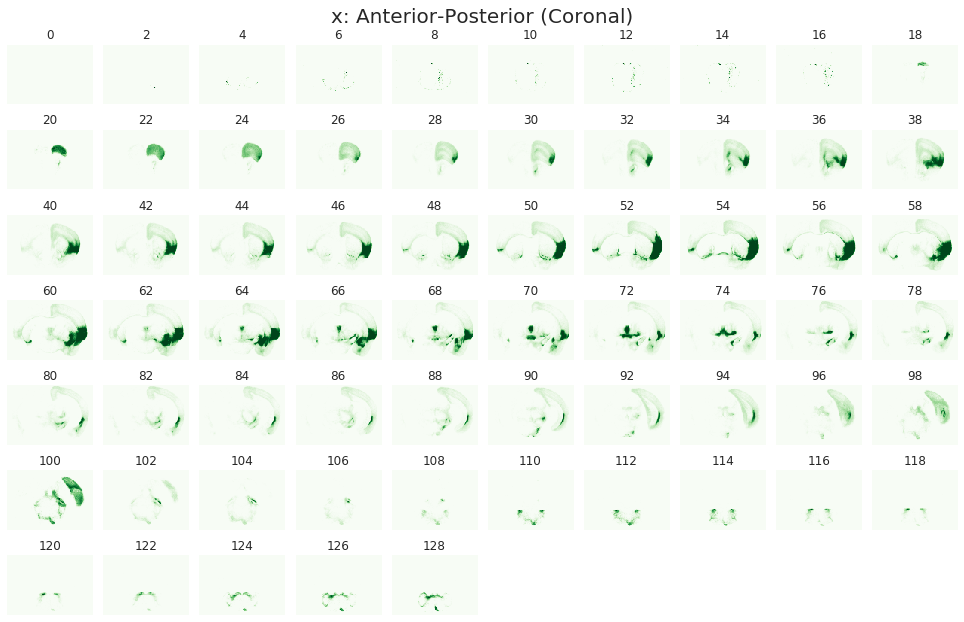

In [9]:
skip_frames = 2
dim = 0

ncols = 10
nrows = int(np.ceil(pjd_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for ctr, idx in enumerate(range(0, pjd_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(pjd.take(idx, axis=dim), cmap='Greens', interpolation='none')
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'x: Anterior-Posterior (Coronal)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

#### Y

Each subplot:
- Vertical: **top -> bottom** corresponds to **Anterior -> Posterior (+x)**
- Horizontal: **left -> right** corresponds to **Left -> Right (+z)**

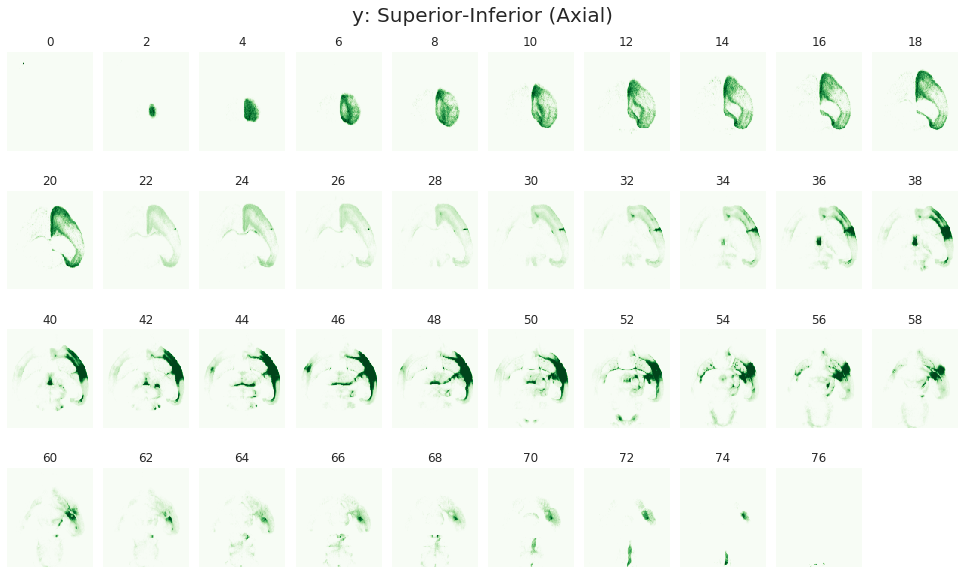

In [10]:
skip_frames = 2
dim = 1

ncols = 10
nrows = int(np.ceil(pjd_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8))

for ctr, idx in enumerate(range(0, pjd_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(pjd.take(idx, axis=dim), cmap='Greens', interpolation='none')
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'y: Superior-Inferior (Axial)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

#### Z

Each subplot:
- Vertical: **top -> bottom** corresponds to **Anterior -> Posterior (+x)**
- Horizontal: **left -> right** corresponds to **Superior -> Inferior (+y)**

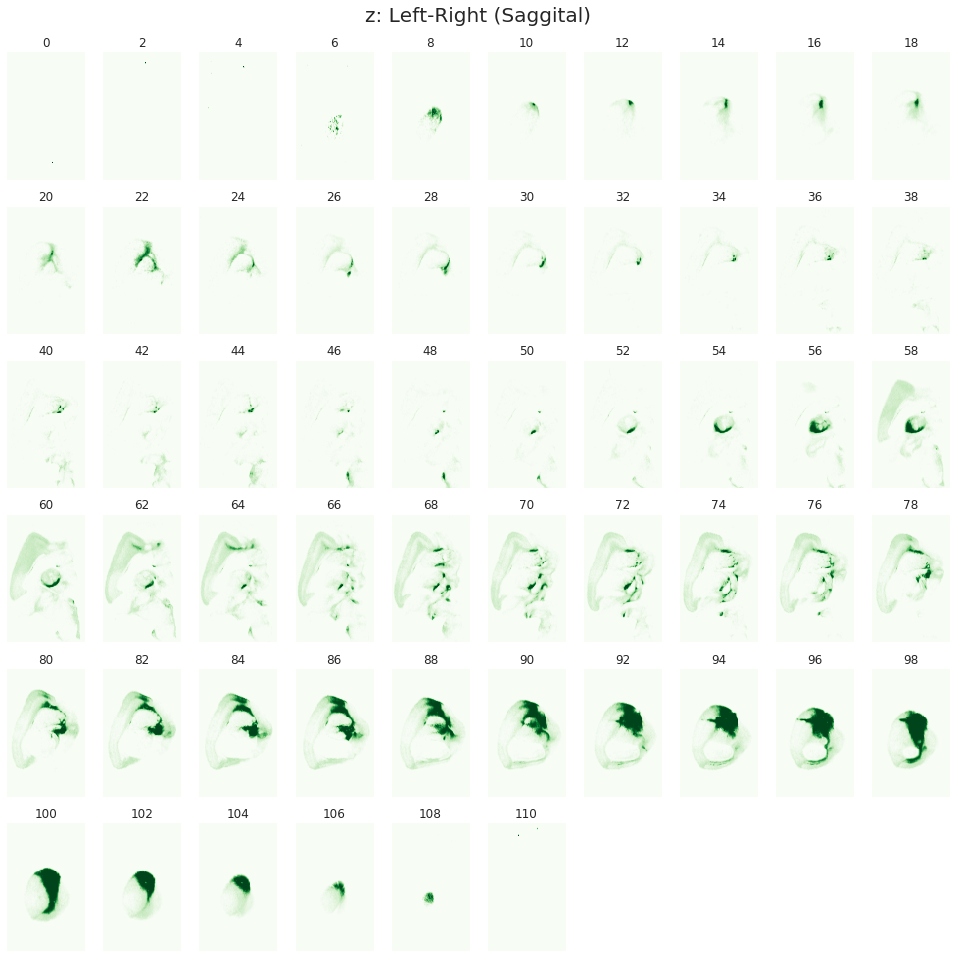

In [11]:
skip_frames = 2
dim = 2

ncols = 10
nrows = int(np.ceil(pjd_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 13))

for ctr, idx in enumerate(range(0, pjd_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(pjd.take(idx, axis=dim), cmap='Greens', interpolation='none')
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'z: Left-Right (Saggital)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

### Plot template

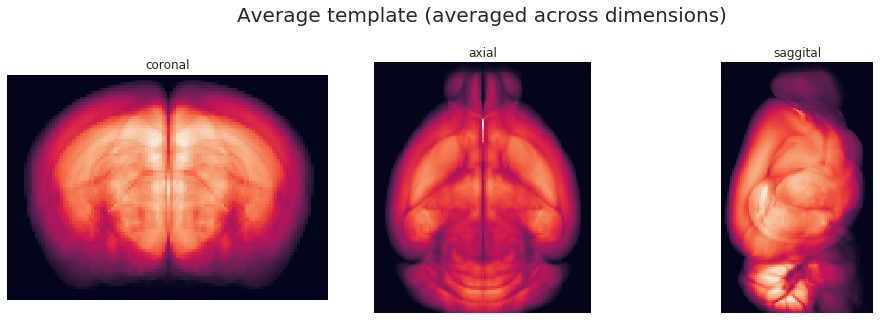

In [12]:
sns.set_style('white')

plt.figure(figsize=(13.5, 4.))
plt.subplot(131)
plt.imshow(template.mean(0))
plt.title('coronal')
plt.axis('off')

plt.subplot(132)
plt.imshow(template.mean(1))
plt.title('axial')
plt.axis('off')

plt.subplot(133)
plt.imshow(template.mean(2))
plt.title('saggital')
plt.axis('off')

plt.suptitle('Average template (averaged across dimensions)', fontsize=20, y=1.1)
plt.tight_layout()
plt.show()

In [13]:
template_info

OrderedDict([('type', 'unsigned short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([132,  80, 114])),
             ('space directions',
              array([[ 100.,    0.,    0.],
                     [   0.,  100.,    0.],
                     [   0.,    0.,  100.]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin', array([ 0.,  0.,  0.]))])

#### X

Each subplot:
- Vertical: **top -> bottom** corresponds to **Superior -> Inferior (+y)**
- Horizontal: **left -> right** corresponds to **Right -> Left (-z)**

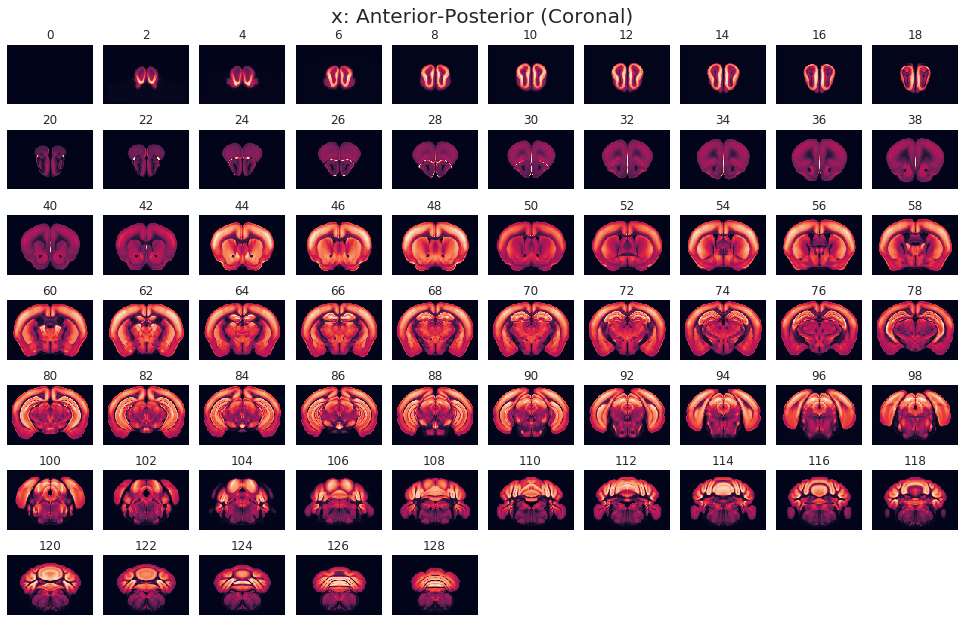

In [14]:
skip_frames = 2
dim = 0

ncols = 10
nrows = int(np.ceil(template_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for ctr, idx in enumerate(range(0, template_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(template.take(idx, axis=dim))
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'x: Anterior-Posterior (Coronal)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

#### Y

Each subplot:
- Vertical: **top -> bottom** corresponds to **Anterior -> Posterior (+x)**
- Horizontal: **left -> right** corresponds to **Left -> Right (+z)**

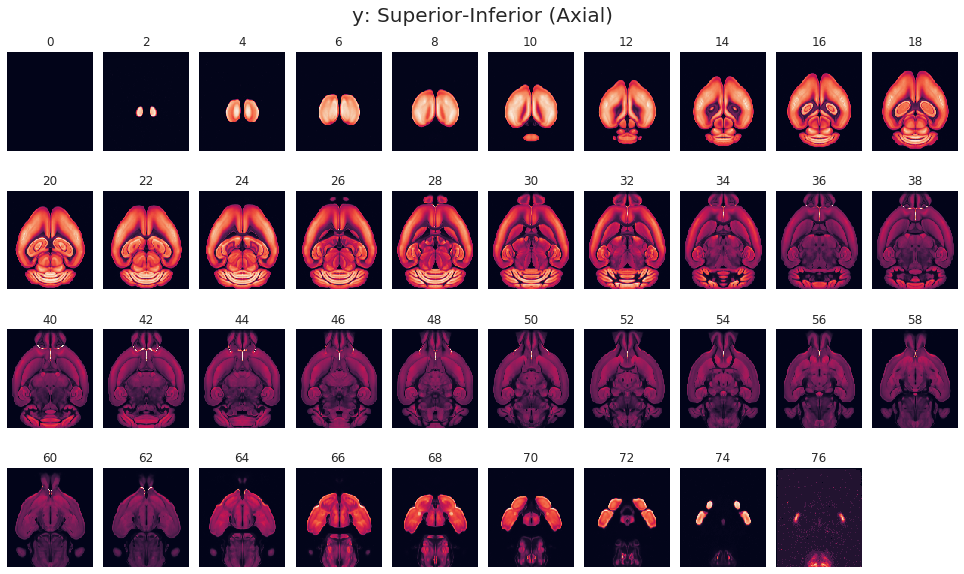

In [15]:
skip_frames = 2
dim = 1

ncols = 10
nrows = int(np.ceil(template_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8))

for ctr, idx in enumerate(range(0, template_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(template.take(idx, axis=dim))
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'y: Superior-Inferior (Axial)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

#### Z

Each subplot:
- Vertical: **top -> bottom** corresponds to **Anterior -> Posterior (+x)**
- Horizontal: **left -> right** corresponds to **Superior -> Inferior (+y)**

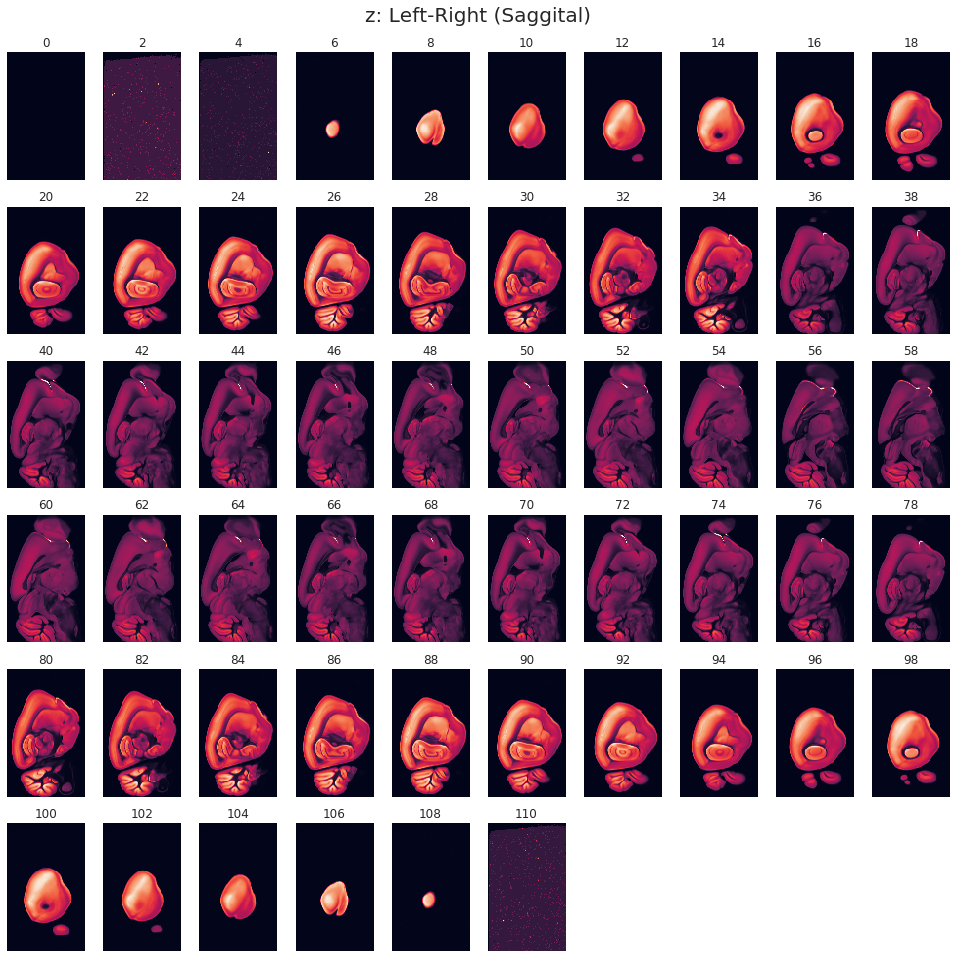

In [16]:
skip_frames = 2
dim = 2

ncols = 10
nrows = int(np.ceil(template_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 13))

for ctr, idx in enumerate(range(0, template_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(template.take(idx, axis=dim))
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'z: Left-Right (Saggital)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

### Plot Annotation

#### X

Each subplot:
- Vertical: **top -> bottom** corresponds to **Superior -> Inferior (+y)**
- Horizontal: **left -> right** corresponds to **Right -> Left (-z)**

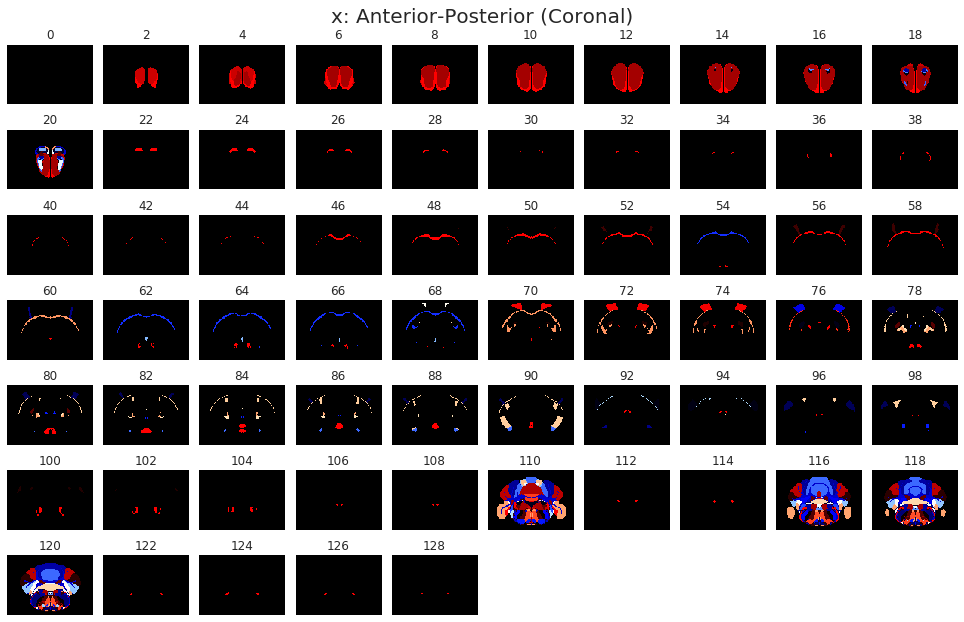

In [17]:
skip_frames = 2
dim = 0

ncols = 10
nrows = int(np.ceil(annot_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for ctr, idx in enumerate(range(0, annot_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(annot.take(idx, axis=dim), cmap='flag_r', interpolation='none')
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'x: Anterior-Posterior (Coronal)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

#### Y

Each subplot:
- Vertical: **top -> bottom** corresponds to **Anterior -> Posterior (+x)**
- Horizontal: **left -> right** corresponds to **Left -> Right (+z)**

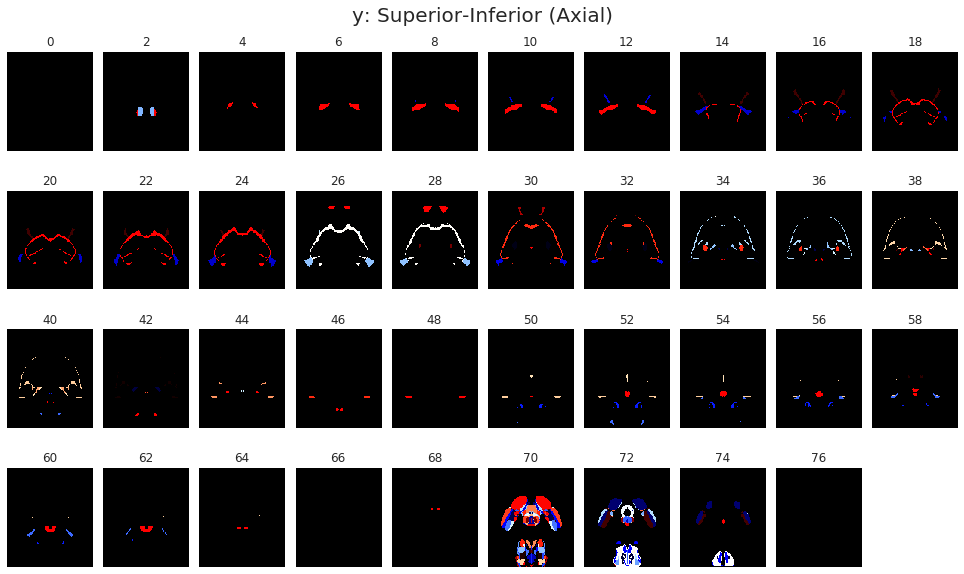

In [18]:
skip_frames = 2
dim = 1

ncols = 10
nrows = int(np.ceil(annot_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8))

for ctr, idx in enumerate(range(0, annot_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(annot.take(idx, axis=dim), cmap='flag_r', interpolation='none')
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'y: Superior-Inferior (Axial)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

#### Z

Each subplot:
- Vertical: **top -> bottom** corresponds to **Anterior -> Posterior (+x)**
- Horizontal: **left -> right** corresponds to **Superior -> Inferior (+y)**

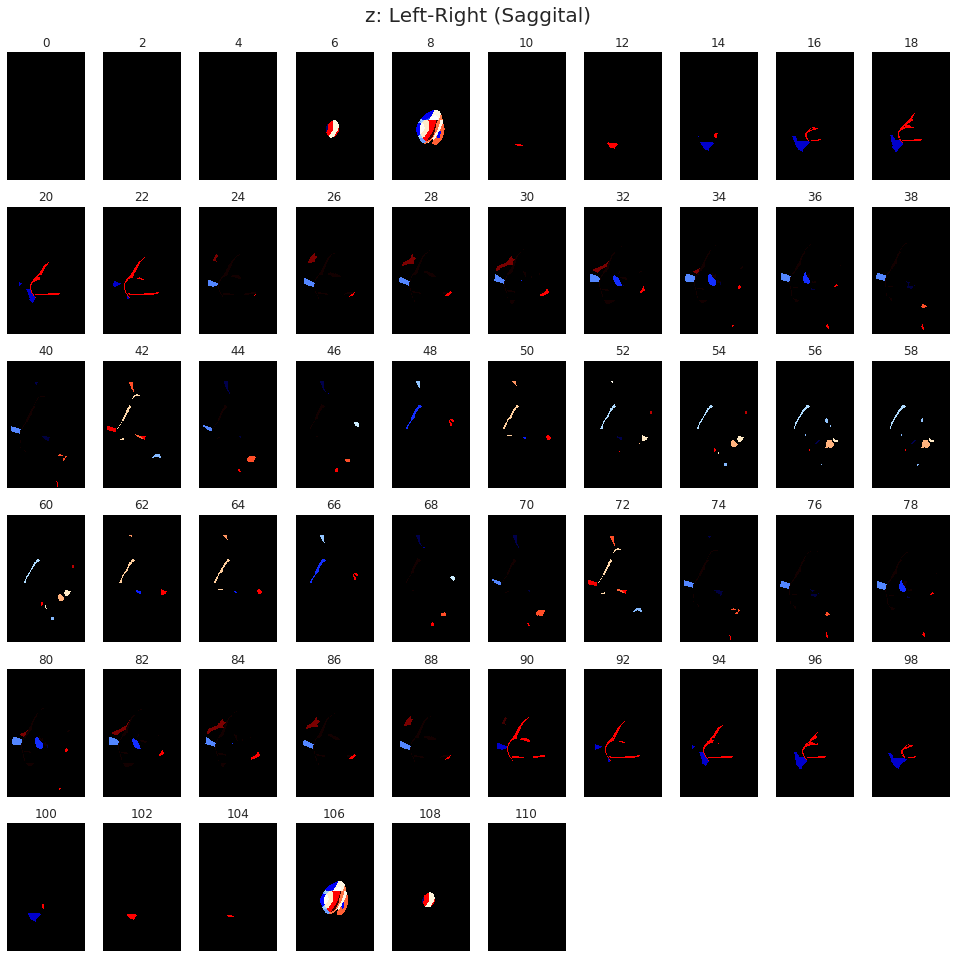

In [19]:
skip_frames = 2
dim = 2

ncols = 10
nrows = int(np.ceil(annot_info['sizes'][dim] / ncols / skip_frames))
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 13))

for ctr, idx in enumerate(range(0, annot_info['sizes'][dim], skip_frames)):
    i, j = ctr//ncols, ctr%ncols
    axes[i, j].imshow(annot.take(idx, axis=dim), cmap='flag_r', interpolation='none')
    axes[i, j].set_title(idx)
    axes[i, j].axis('off')    
axes_flat = trim_axs(axes, i*ncols+j)

msg = 'z: Left-Right (Saggital)'
fig.suptitle(msg, fontsize=20, y=1.02)
fig.tight_layout()
plt.show()

### Summary plot

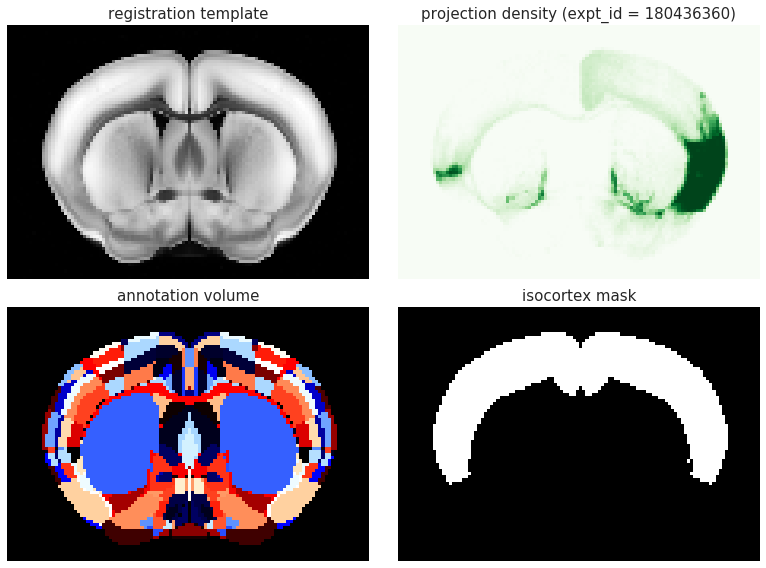

In [20]:
slice_idx = 51


fig, ccf_axes = plt.subplots(2, 2, figsize=(11, 8))

ccf_axes[0, 0].imshow(
    template[slice_idx, :, :],
    cmap='Greys_r',
    aspect='equal',
)
ccf_axes[0, 0].set_title("registration template", fontsize=15)

ccf_axes[0, 1].imshow(
    pjd[slice_idx, :, :],
    cmap='Greens',
    aspect='equal',
)
ccf_axes[0, 1].set_title("projection density (expt_id = {:d})".format(experiment_id), fontsize=15)


ccf_axes[1, 0].imshow(
    annot[slice_idx, :, :],
    cmap='flag_r',
    aspect='equal',
    vmin=0,
    vmax=2000,
)
ccf_axes[1, 0].set_title("annotation volume", fontsize=15)

ccf_axes[1, 1].imshow(
    cortex_mask[slice_idx,:,:],
    cmap='Greys_r',
    aspect='equal',
    vmin=0,
    vmax=1,
)
ccf_axes[1, 1].set_title("isocortex mask", fontsize=15)

for i in range(2):
    for j in range(2):
        ccf_axes[i, j].axis('off')

fig.tight_layout()
plt.show()

## Spatial normalization using ANTs

In [21]:
# reference image
tgt = ants.from_numpy(template.astype(float))

# load
anat_file = '/home/hadi/Downloads/sub-SLC06_ses-1_space-individual_T1w.nii.gz'
mask_file = '/home/hadi/Downloads/sub-SLC06_ses-1_space-individual_desc-mask_bold.nii.gz'

src = ants.image_read(anat_file, reorient='SAR')
mask = ants.image_read(mask_file, reorient='SAR')

src *= mask

In [22]:
src

ANTsImage (SAR)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (78, 64, 64)
	 Spacing    : (0.2, 0.2, 0.2)
	 Origin     : (6.4, -6.2, 7.6)
	 Direction  : [ 0.  0.  1.  0.  1.  0. -1.  0.  0.]

In [23]:
mask

ANTsImage (SAR)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (78, 64, 64)
	 Spacing    : (0.2, 0.2, 0.2)
	 Origin     : (6.4, -6.2, 7.6)
	 Direction  : [ 0.  0.  1.  0.  1.  0. -1.  0.  0.]

In [24]:
tgt

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (132, 80, 114)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 1.  0.  0.  0.  1.  0.  0.  0.  1.]

In [25]:
src_np = filter_boundaries(src.numpy(), mask=src.numpy()!=0)[0]
src = ants.from_numpy(
    data=src_np,
    origin=src.origin,
    spacing=src.spacing,
    direction=src.direction,
)

In [26]:
src

ANTsImage (SAR)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (77, 43, 50)
	 Spacing    : (0.2, 0.2, 0.2)
	 Origin     : (6.4, -6.2, 7.6)
	 Direction  : [ 0.  0.  1.  0.  1.  0. -1.  0.  0.]

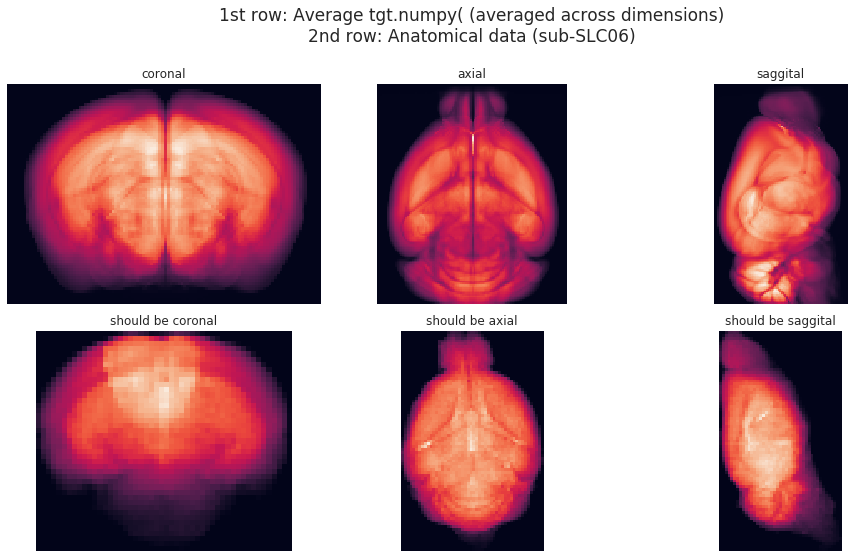

In [27]:
sns.set_style('white')

plt.figure(figsize=(13.5, 7.))
plt.subplot(231)
plt.imshow(tgt.numpy().mean(0))
plt.title('coronal')
plt.axis('off')

plt.subplot(232)
plt.imshow(tgt.numpy().mean(1))
plt.title('axial')
plt.axis('off')

plt.subplot(233)
plt.imshow(tgt.numpy().mean(2))
plt.title('saggital')
plt.axis('off')

plt.subplot(234)
plt.imshow(src.numpy().mean(0))
plt.title('should be coronal')
plt.axis('off')

plt.subplot(235)
plt.imshow(src.numpy().mean(1))
plt.title('should be axial')
plt.axis('off')

plt.subplot(236)
plt.imshow(src.numpy().mean(2))
plt.title('should be saggital')
plt.axis('off')

msg = '1st row: Average tgt.numpy( (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC06)'
plt.suptitle(msg, fontsize=17, y=1.1)
plt.tight_layout()
plt.show()

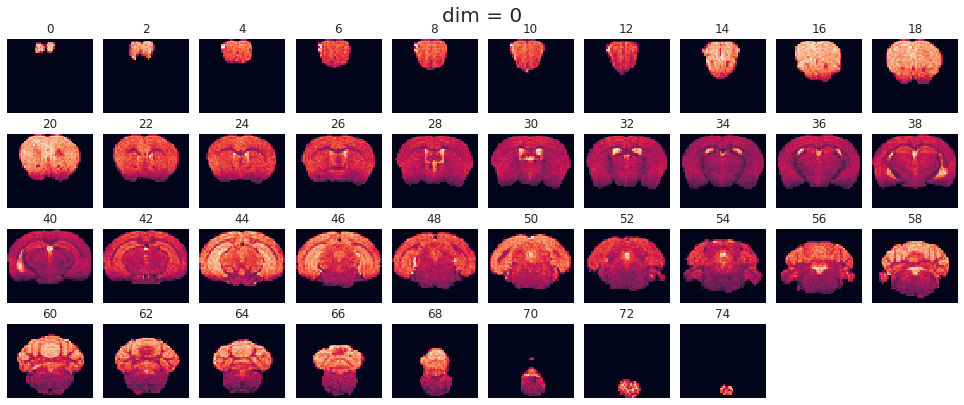

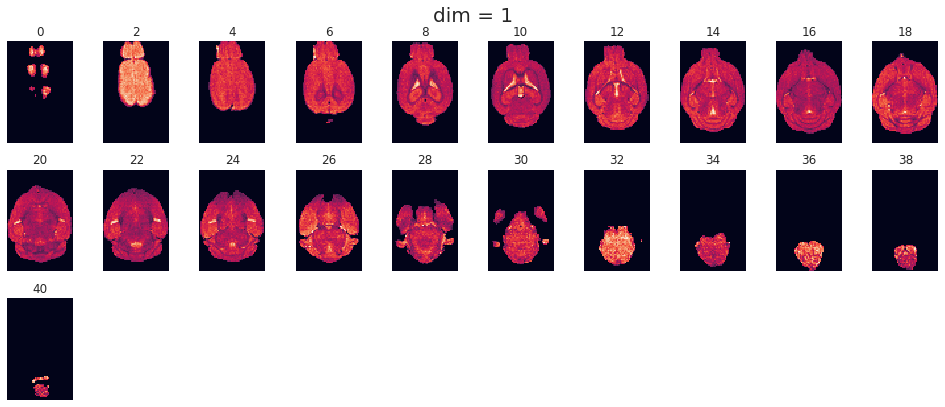

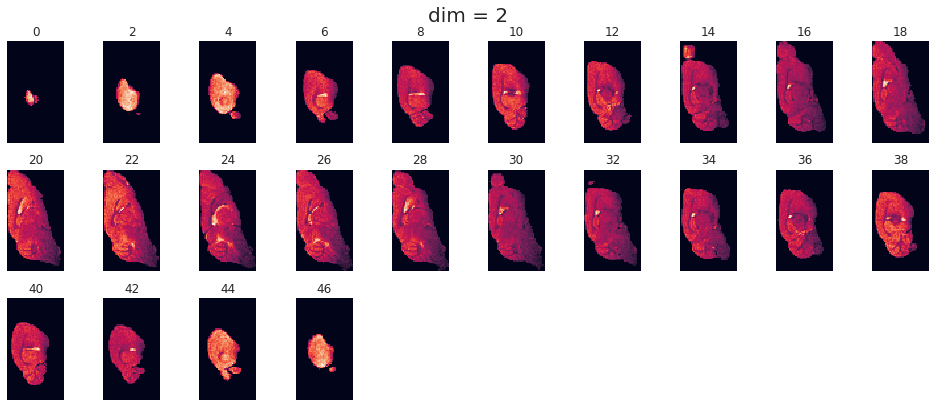

In [32]:
skip_frames = 2
ncols = 10

for dim in range(3):
    nrows = int(np.ceil(src.shape[dim] / ncols / skip_frames))
    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 5.5))

    for ctr, idx in enumerate(range(0, src.shape[dim], skip_frames)):
        i, j = ctr//ncols, ctr%ncols
        axes[i, j].imshow(src.numpy().take(idx, axis=dim))
        axes[i, j].set_title(idx)
        axes[i, j].axis('off')    
    axes_flat = trim_axs(axes, i*ncols+j)

    msg = 'dim = {:d}'.format(dim)
    fig.suptitle(msg, fontsize=20, y=1.02)
    fig.tight_layout()
    plt.show()
    
    print('\n\n')

### Register

#### Example

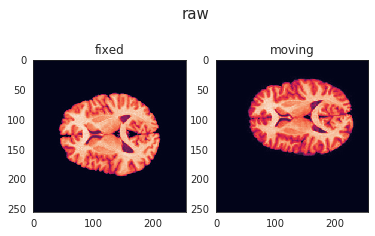

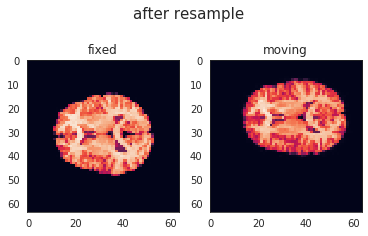

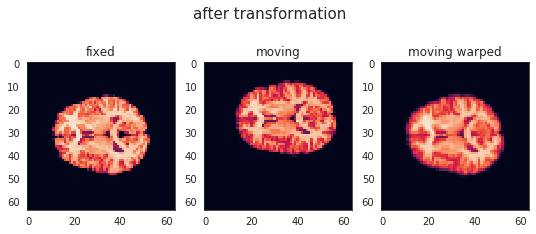

In [33]:
fixed = ants.image_read( ants.get_ants_data('r16') )
moving = ants.image_read( ants.get_ants_data('r64') )

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(fixed.numpy())
plt.title('fixed')
plt.subplot(122)
plt.imshow(moving.numpy())
plt.title('moving')
plt.suptitle('raw', fontsize=15, y=1.1)
plt.show()

fixed = ants.resample_image(fixed, (64,64), 1, 0)
moving = ants.resample_image(moving, (64,64), 1, 0)

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(fixed.numpy())
plt.title('fixed')
plt.subplot(122)
plt.imshow(moving.numpy())
plt.title('moving')
plt.suptitle('after resample', fontsize=15, y=1.1)
plt.show()

mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN')
mywarpedimage = ants.apply_transforms(fixed=fixed, moving=moving, transformlist=mytx['fwdtransforms'])

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.imshow(fixed.numpy())
plt.title('fixed')
plt.subplot(132)
plt.imshow(moving.numpy())
plt.title('moving')
plt.subplot(133)
plt.imshow(mywarpedimage.numpy())
plt.title('moving warped')
plt.suptitle('after transformation', fontsize=15, y=1.1)
plt.show()

### Mouse data

In [34]:
tx = ants.registration(
    fixed=tgt,
    moving=src,
    type_of_transform='SyN',
    verbose=True,
)

In [35]:
tx.keys()

dict_keys(['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms'])

In [36]:
src_tr = ants.apply_transforms(
    fixed=tgt,
    moving=src,
    transformlist=tx['fwdtransforms'],
    interpolator='linear',
)

In [232]:
src_tr

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (132, 80, 114)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 1.  0.  0.  0.  1.  0.  0.  0.  1.]

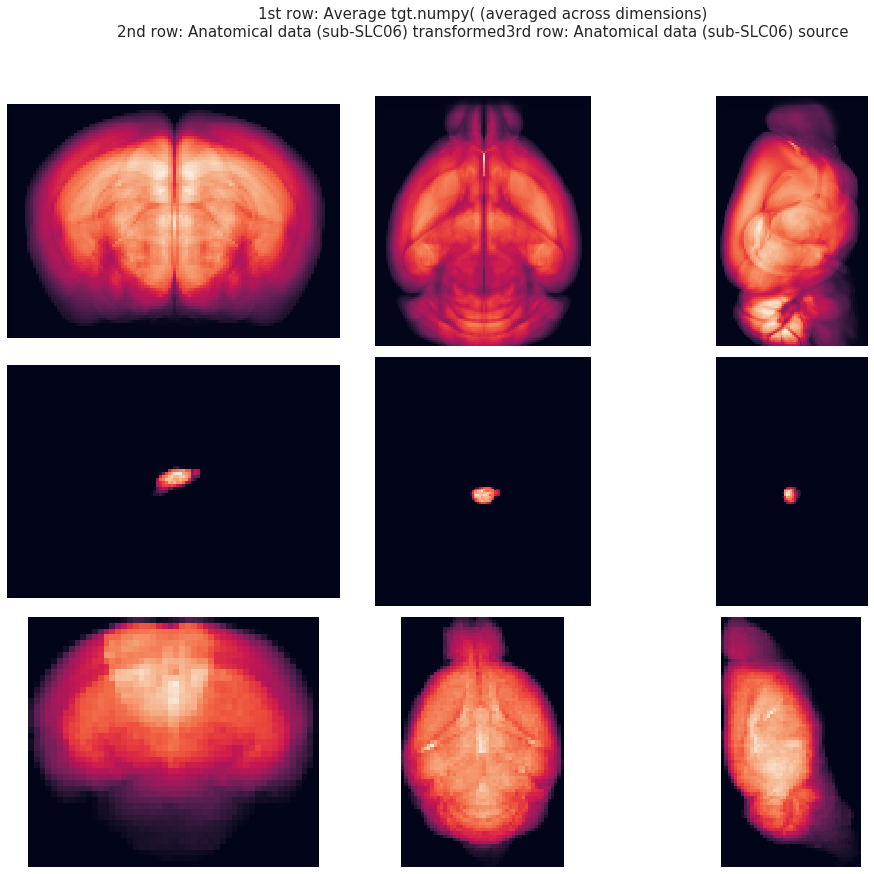

In [233]:
sns.set_style('white')
fig, axes = plt.subplots(3, 3, figsize=(13.5, 11.))

for i in range(3):
    for j in range(3):
        if i == 0:
            data2plt = tgt.numpy()
            title = 'target'
        elif i == 1:
            data2plt = src_tr.numpy()
            title = 'transformed'
        else:
            data2plt = src.numpy()
            title = 'source'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].axis('off')

msg = '1st row: Average tgt.numpy( (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC06) transformed'
msg += '3rd row: Anatomical data (sub-SLC06) source'
plt.suptitle(msg, fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

### Why not working?

In [37]:
src.shape, tgt.shape

((77, 43, 50), (132, 80, 114))

In [38]:
src_resampled = ants.resample_image(src, tgt.shape, 1, 0)
# tgt = ants.resample_image(tgt, (60, 60, 60), 1, 0)

In [39]:
src.shape, tgt.shape, src_resampled.shape

((77, 43, 50), (132, 80, 114), (132, 80, 114))

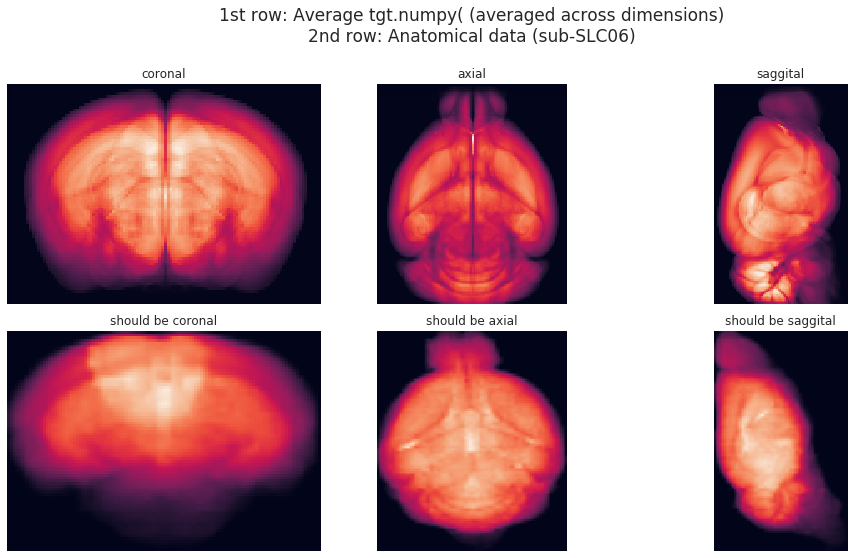

In [40]:
sns.set_style('white')

plt.figure(figsize=(13.5, 7.))
plt.subplot(231)
plt.imshow(tgt.numpy().mean(0))
plt.title('coronal')
plt.axis('off')

plt.subplot(232)
plt.imshow(tgt.numpy().mean(1))
plt.title('axial')
plt.axis('off')

plt.subplot(233)
plt.imshow(tgt.numpy().mean(2))
plt.title('saggital')
plt.axis('off')

plt.subplot(234)
plt.imshow(src_resampled.numpy().mean(0))
plt.title('should be coronal')
plt.axis('off')

plt.subplot(235)
plt.imshow(src_resampled.numpy().mean(1))
plt.title('should be axial')
plt.axis('off')

plt.subplot(236)
plt.imshow(src_resampled.numpy().mean(2))
plt.title('should be saggital')
plt.axis('off')

msg = '1st row: Average tgt.numpy( (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC06)'
plt.suptitle(msg, fontsize=17, y=1.1)
plt.tight_layout()
plt.show()

In [41]:
tx = ants.registration(
    fixed=tgt,
    moving=src_resampled,
    type_of_transform='SyN',
    verbose=True,
)

In [42]:
tx.keys()

dict_keys(['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms'])

In [49]:
src_tr = ants.apply_transforms(
    fixed=tgt,
    moving=src_resampled,
    transformlist=tx['fwdtransforms'],
    interpolator='linear',
)

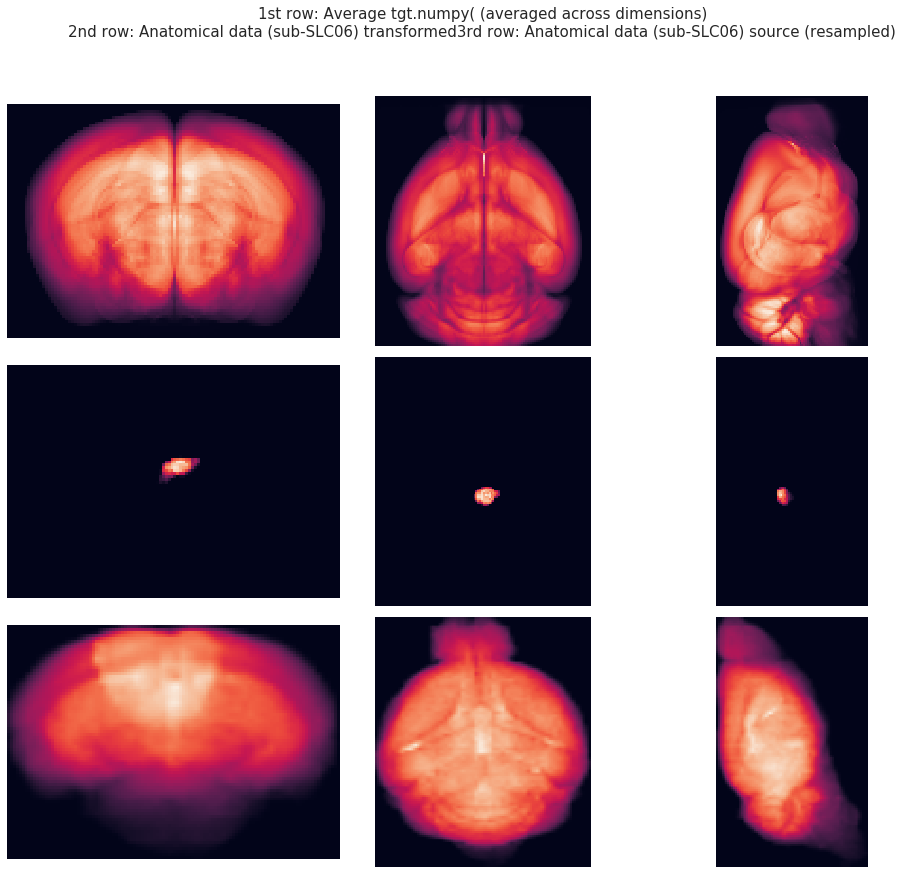

In [50]:
sns.set_style('white')
fig, axes = plt.subplots(3, 3, figsize=(13.5, 11.))

for i in range(3):
    for j in range(3):
        if i == 0:
            data2plt = tgt.numpy()
            title = 'target'
        elif i == 1:
            data2plt = src_tr.numpy()
            title = 'transformed'
        else:
            data2plt = src_resampled.numpy()
            title = 'source'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].axis('off')

msg = '1st row: Average tgt.numpy( (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC06) transformed'
msg += '3rd row: Anatomical data (sub-SLC06) source (resampled)'
plt.suptitle(msg, fontsize=15, y=1.1)
plt.tight_layout()
plt.show()